# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


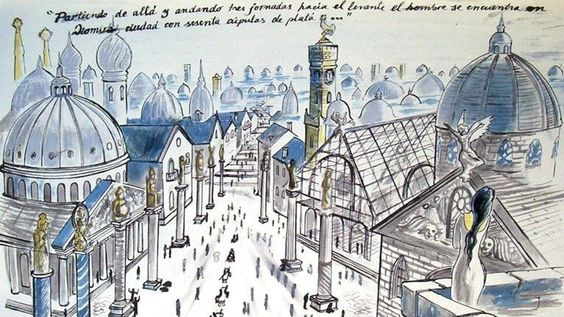

In [4]:
Image(filename='../Images/Diomira.jpg') 

## DIOMIRA notebook 

Notes for DIOMIRA script.

DIOMIRA Script:
        1. Reads an Nh5 file produced by art/centella, which stores the
            pre-raw data (PRD) (number of pes) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC.

        2. Simulates the response of the energy plane in the PMTs PRD, and
            outputs PMT Raw-Data (RD), e.g., waveforms in bins of 25 ns
            which correspond to the output of the EP FEE.
            
        3. Simulates the response of the tracking plane in the SiPMs PRDs and outputs
            SiPM RD (not yet implemented, for the time being simply copy the SiPM PRD)

        4. Adds two new vectors, storing the total energy in pes (true MC) for each PMT and each SiPM

        5. Add a table describing the FEE parameters used for simulation

        6. Copies the tables on geometry, detector data and MC

In [5]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

### Configuration

The configuration of the script can be stored in a configuration file or read from the command line. The parameters are self-explaining. RUN_ALL is used to decide whether to run all the events in the file in case that the total number of events requested (LAST_EVT-FIRST_EVT) exceeds the number of events in the DST file. If RUN_ALL is set to 1 (True), the script will run over all elements in the DST, otherwise it will exit with a warning.

#Configuration file for DIOMIRA
PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL,END 
/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/,/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/,WF_Tl_0.h5,WF_Tl_0_RWF.h5,0,100,1,1

<font color='red'> ND: There seems to be a bug in the read_csv function such that the last column gives a
key error access. As a temporary fix add dummy variable END (which is never accessed) </font>

In [6]:
path_config = '/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DIOMIRA_default.csv'

In [7]:
conf =pd.read_csv(path_config,skiprows=1)

In [8]:
conf

,PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL,END
0,/Users/jjgomezcadenas/Documents/Development/NE...,/Users/jjgomezcadenas/Documents/Development/NE...,WF_Tl_0.h5,WF_Tl_0_RWF.h5,0,99,1,1


In [9]:
conf.keys()

Index([u'PATH_IN', u'PATH_OUT', u'FILE_IN', u'FILE_OUT', u'FIRST_EVT',
       u'LAST_EVT', u'RUN_ALL', u'END '],
      dtype='object')

In [10]:
conf.values

array([['/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/',
        '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/',
        'WF_Tl_0.h5', 'WF_Tl_0_RWF.h5', 0, 99, 1, 1]], dtype=object)

In [11]:
conf.values[0][0]

'/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/'

In [12]:
conf['PATH_IN']

0    /Users/jjgomezcadenas/Documents/Development/NE...
Name: PATH_IN, dtype: object

In [13]:
conf['RUN_ALL']

0    1
Name: RUN_ALL, dtype: int64

In [14]:
lst_evt =conf['LAST_EVT'][0]

In [15]:
lst_evt

99

In [16]:
type(lst_evt)

numpy.int64

In [17]:
run ../Cities/DIOMIRA.py

Path to configuration file not given

        Usage: python (run) DIOMIRA [args]
        where args are:
         -h (--help) : this text
         -i (--info) : print a text describing the invisible city of DIOMIRA
         -d (--debug) : can be set to 'DEBUG','INFO','WARNING','ERROR'
         -c (--cfile) : full path to a configuration file
         
         example of configuration file 

        #Header is not read
        Names of parameters (comma separated)
        Values of parameters (comma separated)
        
        The parameters for DIOMIRA are:
        PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL 

        The parameters are self-explaining. 
        RUN_ALL is used to decide whether to run all the events in the file 
        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (True), 
        the script will run over all elements in the DST, 
        otherwise

### Execution time

In [18]:
%time %run ../Cities/DIOMIRA.py -c ../Config/DIOMIRA_NA_ZLIB.csv


        Configuration parameters 
 
                                                     PATH_IN  \
0  /Users/jjgomezcadenas/Documents/Development/NE...   

                                            PATH_OUT  \
0  /Users/jjgomezcadenas/Documents/Development/NE...   

                          FILE_IN         FILE_OUT  FIRST_EVT  LAST_EVT  \
0  WF_Na_1Kevts_comp1_chunk32k.h5  WF_Na_1k_RWF.h5          0       999   

   RUN_ALL  END   
0        1     1  
        

Leaving there and proceeding for three days toward the east, you reach Diomira, 
a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, 
a crystal theater, a golden cock that crows every morning on a tower. 
All these beauties will already be familiar to the visitor, 
who has seen them also in other cities. 
But the special quality of this city for the man who arrives there on a September evening, 
when the days are growing shorter 
and the multicolored lamps are lighted all at once at the d

The execution time when the input file has been compressed with BLOSC is 1min 24s for 99 events thus less than 1s per event.

### File Structure

In [23]:
h5out = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k_RWF.h5', "r+") 

In [24]:
h5out

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "CO12": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32Col(sha

### Testing file: compute energy of PMTs

In [25]:
def energy_pes(event_number, sensord):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    rdata = []

    for j in range(sensord.shape[1]):
        swf = sensord[event_number, j]
        ene = np.sum(swf)
        rdata.append(ene)
        
    return np.array(rdata) 

In [26]:
pmtrd_ = h5out.root.RD.pmtrd

In [27]:
pmtrd_.shape

(999, 12, 24000)

In [28]:
epes = energy_pes(0, pmtrd_)

In [29]:
epes.shape

(12,)

In [31]:
epes

array([ 1233,  1538,   -69,   951,  -779,  1888,  -722,  3232,  2973,
         692, -2579,  1194])

Negative energy in some of them, and small numbers anyway. This is due to the negative swing!

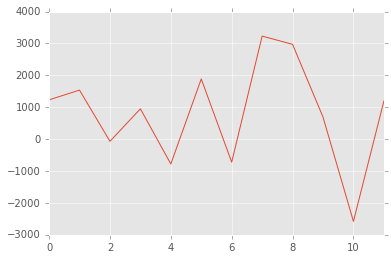

In [30]:
pd.Series(epes).plot()

In [ ]:
h5in = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF_Tl_0.h5', "r+") 

In [ ]:
h5in

In [ ]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/WF_Na_0_100evts_comp1_chunk32k.h5'

In [ ]:
h5in = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/WF_Na_0_100evts_comp1_chunk32k.h5', "r+") 

In [ ]:
h5in

### Space in disk

In [ ]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF_Tl_0.h5'

In [ ]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0_RWF.h5'

<font color='red'>Notice that the output file is larger than the input file in spite of the fact that the Waveforms stored in RWF are much smaller in size (by a factor 25) than the 1ns Waveforms. A possible reason for that: In the 1ns Waveforms most of the data are ceros, which can be efficiently removed by the compressor, while in the RWF data, we have introduced noise and the effect of the FEE. The baseline fluctuates around cero but is not exactly cero and thus cannot be removed so efficiently (tbc by FA)</font>

### Files compressed with zlib

In [ ]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB'

In [ ]:
path_config = '/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DIOMIRA_NA_ZLIB.csv'

In [ ]:
conf =pd.read_csv(path_config,skiprows=1)

In [ ]:
conf

In [ ]:
%time %run ../Cities/DIOMIRA.py -c ../Config/DIOMIRA_NA_ZLIB.csv

<font color='red'>CPU times: user 1min 15s, sys: 8.83 s, total: 1min 24s
Wall time: 1min 30s</font>

#### The DIOMIRA execution time for files compressed with ZLIB and with BLOSC is the same!!! Good news! 

In [ ]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/'

#### The space in disk of the RWF files is also the same (as expected) 

In [ ]:
h5out = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_0_RWF.h5', "r+") 

In [ ]:
h5out